In [1]:
using Random
using Distributions
using StatsBase
using FLoops

# compile local files
include("statistics.jl")
include("simulation.jl")
include("data.jl")
include("util.jl")

using .TestStatistics
using .Simulation
using .Data

In [116]:
"""
CONFIG
"""
alpha = 0.05

# data
B  = 100    # num. coverage probabilities per boxplot
S  = 1800   # num. samples per coverage probability
nx = 8      # size of group 1
ny = 8      # size of group 2
px, py = partition(nx, ny)
dtype = Float32

# distribution settings
Random.seed!(123)

distrTypeX = LogNormal
muX = dtype.(rand(Uniform(0, 1), B))
sdX = 2 * muX
paramsX = (muX, sdX)

distrTypeY = LogNormal
muY = dtype.(rand(Uniform(0, 1), B))
sdY = 2 * muY
paramsY = (muY, sdY)

(Float32[0.95415926, 0.8458951, 0.5867487, 0.12181264, 0.13776624, 0.050808292, 0.38644013, 0.8464582, 0.12353812, 0.7400203  …  0.50178707, 0.9408054, 0.49614337, 0.59768474, 0.12992169, 0.40748566, 0.54188573, 0.7761893, 0.07168031, 0.93268365], Float32[1.9083185, 1.6917902, 1.1734974, 0.24362528, 0.27553248, 0.101616584, 0.77288026, 1.6929164, 0.24707624, 1.4800406  …  1.0035741, 1.8816108, 0.99228674, 1.1953695, 0.25984338, 0.8149713, 1.0837715, 1.5523787, 0.14336061, 1.8653673])

In [ ]:
"""
distrTypeX = Exponential
lambdaX = dtype.(rand(Uniform(1, 20), B))
paramsX = (lambdaX,)

distrTypeY = Exponential
lambdaY = dtype.(rand(Uniform(1, 20), B))
paramsY = (lambdaY,)


distrTypeX = LogNormal
muX = dtype.(rand(Uniform(0, 1), B))
sdX = 2 * muX
paramsX = (muX, sdX)

distrTypeY = LogNormal
muY = dtype.(rand(Uniform(0, 1), B))
sdY = 2 * muY
paramsY = (muY, sdY)


distrTypeX = Gamma
shapeX = dtype.(rand(Uniform(1, 5), B))
scaleX = 4 * shapeX
paramsX = (shapeX, scaleX)

distrTypeY = Gamma
shapeY = dtype.(rand(Uniform(1, 5), B))
scaleY = 4 * shapeY
paramsY = (shapeY, scaleY)
"""

In [120]:
# generate data
Random.seed!(123)
x, y, wide, narrow, deltas, distrX, distrY = Data.generateData(B, S, nx, ny, true,
                                                          distrTypeX, paramsX,
                                                          distrTypeY, paramsY)
@show size(x)
@show size(y)
@show size(wide)
@show size(narrow)
@show deltas[1]
@show distrX[1]
@show distrY[1]
x[1:5]

size(x) = (8, 1800, 100)
size(y) = (8, 1800, 100)
size(wide) = (1800, 100)
size(narrow) = (1800, 100)
deltas[1] = -3.2435703f0
distrX[1] = LogNormal{Float32}(μ=0.90629965f0, σ=1.8125993f0)
distrY[1] = LogNormal{Float32}(μ=0.95415926f0, σ=1.9083185f0)


5-element Vector{Float32}:
 0.7678574
 0.17447239
 0.13046591
 1.6682247
 6.0408444

In [4]:
# wrap constant arguments into an iterable object
# this allows each batch to have local access

struct Args
    px::AbstractMatrix{Int}
    py::AbstractMatrix{Int}
    pooled::Bool
    alpha::Float32
    alt_lo::Alternative
    alt_hi::Alternative
end

Base.Broadcast.broadcastable(obj::Args) = Ref(obj)  # make objects of this type iterable

In [37]:
basesize = ceil(Int, B / Threads.nthreads())

@time for isTwoSided in [true, false]
    alpha_temp = alpha
    alt_lo = alt_hi = twoSided
    
    if !isTwoSided
        alpha_temp = alpha / 2
        alt_lo = greater
        alt_hi = smaller
    end
        
    for pooled in [true, false]
        args = Args(px, py, pooled, alpha_temp, alt_lo, alt_hi)
        
        
        results = Vector{Any}(undef, B)
        
        @floop ThreadedEx(basesize = 1) for i = 1:B
            @floop ThreadedEx() for j = 1:S
                @inbounds a, b = Simulation.permInterval(x[:,j,i], y[:,j,i], wide[j,i], narrow[j,i], deltas[i], args)
                @reduce() do (coverage = 0; a), (width = 0.0f0; b)
                    coverage += a
                    width += b
                end
            end
            results[i] = (coverage / S, width / S)
        end
        
        save(results, distrX, distrY, pooled, args.alpha, isTwoSided)
    end
end

 33.805197 seconds (24.15 M allocations: 140.501 GiB, 25.39% gc time, 0.66% compilation time)


In [127]:
for pooled in [true, false]
    tconfs = TestStatistics.tconf(x, y, pooled=pooled, alpha=alpha)
    tconfs = reshape(tconfs, S, B)

    results = Vector{Any}(undef, B)

    for i in 1:B
        coverage = width = 0

        for j in 1:S
            lo, hi = tconfs[j, i]
            coverage += (lo <= deltas[i] <= hi)
            width += (hi - lo)
        end
        results[i] = (coverage / S, width / S)
    end

    save(results, distrX, distrY, pooled, alpha, prefix="t")
end

In [92]:
function bootstrap_ci(x, y, nx=length(x), ny=length(y); alpha=0.05, trials=10_000)
    testStat = zeros(trials)
    for i in 1:trials
        x_bs = StatsBase.sample(x, nx)
        y_bs = StatsBase.sample(y, ny)
        @inbounds testStat[i] = mean(x_bs) - mean(y_bs)
    end
    sort!(testStat)
    quantileSize = ceil(Int, trials * alpha)
    return testStat[quantileSize], testStat[end-quantileSize+1]
end

bootstrap_ci (generic function with 3 methods)

In [122]:
for pooled in [true, false]
    results = Vector{Any}(undef, B)
    
    for i in 1:B
        coverage = width = 0
        for j in 1:S
            lo, hi = bootstrap_ci(x[:,j,i], y[:,j,i], alpha=alpha)
            coverage += (lo <= deltas[i] <= hi)
            width += (hi - lo)
        end
        results[i] = (coverage / S, width / S)
    end
    
    save(results, distrX, distrY, pooled, alpha, prefix="bs")
end

---

In [10]:
args = Args(px, py, true, 0.05, twoSided, twoSided)
results = Vector{Any}(undef, B)

@time @floop ThreadedEx(basesize = 1) for i = 1:B
    @floop ThreadedEx() for j = 1:S
        @inbounds a, b = Simulation.permInterval(x[:,j,i], y[:,j,i], wide[j,i], narrow[j,i], deltas[i], args)
        @reduce() do (coverage = 0; a), (width = 0.0f0; b)
            coverage += a
            width += b
        end
    end
    results[i] = (coverage / S, width / S)
end

results

  7.290868 seconds (7.21 M allocations: 43.391 GiB, 20.35% gc time, 2.26% compilation time)


2-element Vector{Any}:
 (0.6005555555555555, 32.00039f0)
 (0.7633333333333333, 6.2128906f0)

In [3]:
using StatsPlots

# investigate setting with lowest average coverage probability
distrX = LogNormal{Float32}(0.9914051f0, 1.9828103f0)
distrY = LogNormal{Float32}(0.0039391504f0, 1.9839215f0)
Random.seed!(123)
x = rand(distrX, nx)
y = rand(distrY, ny)
pooled = true
ts = Simulation.testStatDistr(x, y, px, py, pooled)

1×12870 Matrix{Float64}:
 1.38501  -0.634696  -0.558848  -0.525251  …  0.558848  0.634696  -1.38501

In [4]:
wide   = tconf(x, y, alpha=0.00001, pooled=pooled)
narrow = tconf(x, y, alpha=0.4, pooled=pooled)

1-element Vector{Tuple{Float32, Float32}}:
 (3.6575227, 15.940668)

In [10]:
wide_lo, wide_hi = wide[1]
narrow_lo, narrow_hi = narrow[1]

lo = Simulation.search(x, y, wide_lo, narrow_lo,
                       px, py, pooled, twoSided, 0.05, isLowerBound=true, margin=0.005)#, margin=0.005, threshold=0.5)
@show lo

hi = Simulation.search(x, y, narrow_hi, wide_hi,
                       px, py, pooled, twoSided, 0.05, isLowerBound=false, margin=0.005)#, margin=0.005, threshold=0.5)
@show hi

(start, stop) = (-37.649715f0, 3.6575227f0)
(start, stop) = (-16.996096f0, 3.6575227f0)
(start, stop) = (-6.6692867f0, 3.6575227f0)
(start, stop) = (-1.505882f0, 3.6575227f0)
(start, stop) = (-1.505882f0, 1.0758203f0)
(start, stop) = (-1.505882f0, -0.21503085f0)
condition 2
lo = -0.86045647f0
(start, stop) = (15.940668f0, 57.247906f0)
(start, stop) = (15.940668f0, 36.594288f0)
(start, stop) = (15.940668f0, 26.267479f0)
(start, stop) = (21.104073f0, 26.267479f0)
(start, stop) = (23.685776f0, 26.267479f0)
(start, stop) = (24.976627f0, 26.267479f0)
(start, stop) = (24.976627f0, 25.622053f0)
condition 2
hi = 25.29934f0


25.29934f0

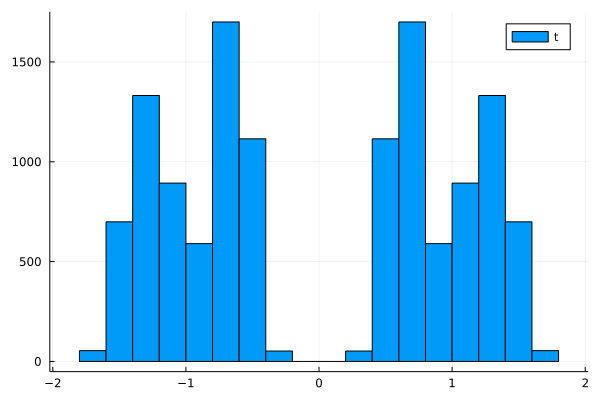

In [5]:
histogram(vec(ts), labels="t")

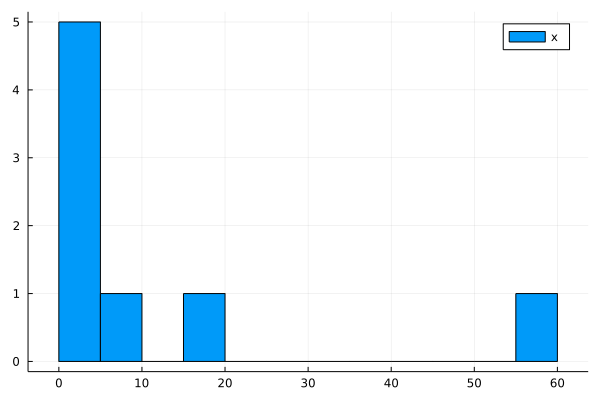

In [37]:
histogram(x, bins=20, label="x")

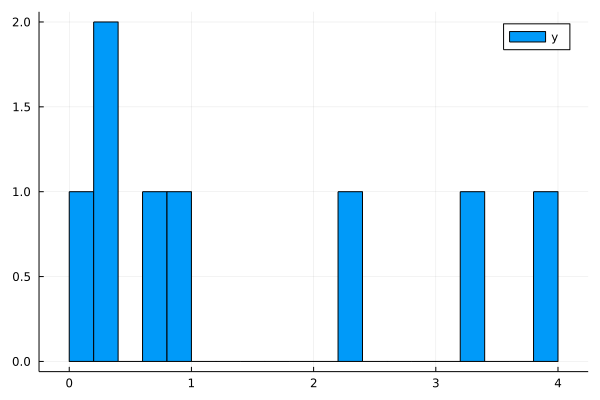

In [38]:
histogram(y, bins=20, label="y")

In [152]:
mean(distrX) - mean(distrY)

12.059104f0

In [160]:
mean(x) - mean(y)

9.799095570369964

In [5]:
pvals = []
delta_true = mean(distrX) - mean(distrY)
deltas = LinRange(delta_true - 10, delta_true + 60, 1000)
for delta in deltas
    push!(pvals, Simulation.pval(x, y, delta, px, py, true, twoSided))
end

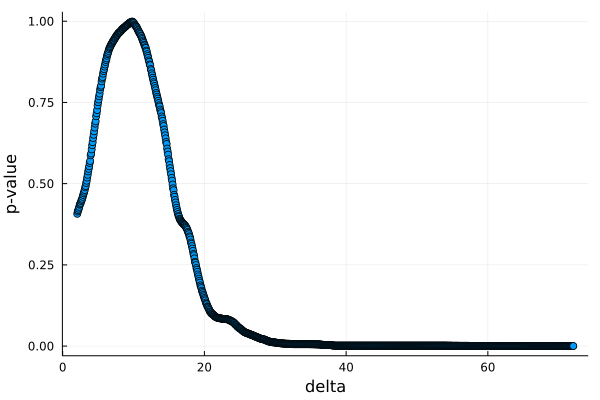

In [6]:
scatter(collect(zip(deltas, pvals)), xlabel = "delta", ylab = "p-value", legend=false)

In [7]:
Simulation.pval(x, y, 36, px, py, pooled, twoSided)

0.0052836053f0

In [9]:
tconfs

3600-element Vector{Tuple{Float32, Float32}}:
 (-19.406889, 13.681335)
 (-10.254034, 22.495975)
 (-15.051459, 3.5213578)
 (-10.473377, 25.579975)
 (-8.148141, 18.080564)
 (-15.213826, 16.16148)
 (-28.95088, 1.4654028)
 (-19.25335, 18.583445)
 (-14.463757, 23.951908)
 (-15.911758, 18.85961)
 (-15.553227, 11.926515)
 (-8.077089, 32.580215)
 (-18.512327, 26.410967)
 ⋮
 (-2.9101288, 26.016361)
 (-6.8090806, 10.315159)
 (-5.884563, 16.12337)
 (-20.571823, 5.414329)
 (-13.059308, 7.097564)
 (-7.066851, 17.959782)
 (-14.210773, 7.0302143)
 (-3.529798, 15.88557)
 (-7.9502907, 23.713247)
 (-7.7267528, 12.080895)
 (-9.459779, 10.719087)
 (-12.733841, 8.496998)

In [21]:
TestStatistics.tconf(x[:,1,end], y[:,1,end])

1-element Vector{Tuple{Float32, Float32}}:
 (-14.325505, 8.080132)

In [23]:
deltas

2-element Vector{Float32}:
 -1.4786596
  1.5836003

In [26]:
tconfs = TestStatistics.tconf(x, y, pooled, )
tconfs = reshape(tconfs, S, B)

for i in 1:B
    coverage = 0
    for j in 1:S
        lo, hi = tconfs[j, i]
        coverage += (lo <= deltas[i] <= hi)
    end
    @show coverage / S
end

coverage

coverage / S = 0.9505555555555556
coverage / S = 0.9477777777777778


1706

In [22]:
tconfs = reshape(tconfs, S, B)

1800×2 Matrix{Tuple{Float32, Float32}}:
 (-19.4069, 13.6813)    (-14.3255, 8.08013)
 (-10.254, 22.496)      (-3.21494, 16.4706)
 (-15.0515, 3.52136)    (-1.39995, 16.5024)
 (-10.4734, 25.58)      (-21.3382, -1.27217)
 (-8.14814, 18.0806)    (-9.09834, 21.7493)
 (-15.2138, 16.1615)    (-10.8006, 15.1964)
 (-28.9509, 1.4654)     (-12.432, 6.15023)
 (-19.2533, 18.5834)    (-2.44271, 22.5527)
 (-14.4638, 23.9519)    (-13.4074, 5.39243)
 (-15.9118, 18.8596)    (-12.7131, 10.76)
 (-15.5532, 11.9265)    (-15.8909, 6.0293)
 (-8.07709, 32.5802)    (-1.65557, 12.5146)
 (-18.5123, 26.411)     (-3.94247, 14.1742)
 ⋮                      
 (-5.13854, 19.6827)    (-2.91013, 26.0164)
 (-27.99, 2.35133)      (-6.80908, 10.3152)
 (-12.4076, 14.9063)    (-5.88456, 16.1234)
 (-15.0388, 28.5754)    (-20.5718, 5.41433)
 (-20.1403, 3.37028)    (-13.0593, 7.09756)
 (-32.7732, 2.08593)    (-7.06685, 17.9598)
 (-18.3907, 23.4897)    (-14.2108, 7.03021)
 (-24.8617, 8.18466)    (-3.5298, 15.8856)
 (-13.8823, 17.

In [19]:
tconfs

3600-element Vector{Tuple{Float32, Float32}}:
 (-19.406889, 13.681335)
 (-10.254034, 22.495975)
 (-15.051459, 3.5213578)
 (-10.473377, 25.579975)
 (-8.148141, 18.080564)
 (-15.213826, 16.16148)
 (-28.95088, 1.4654028)
 (-19.25335, 18.583445)
 (-14.463757, 23.951908)
 (-15.911758, 18.85961)
 (-15.553227, 11.926515)
 (-8.077089, 32.580215)
 (-18.512327, 26.410967)
 ⋮
 (-2.9101288, 26.016361)
 (-6.8090806, 10.315159)
 (-5.884563, 16.12337)
 (-20.571823, 5.414329)
 (-13.059308, 7.097564)
 (-7.066851, 17.959782)
 (-14.210773, 7.0302143)
 (-3.529798, 15.88557)
 (-7.9502907, 23.713247)
 (-7.7267528, 12.080895)
 (-9.459779, 10.719087)
 (-12.733841, 8.496998)

In [7]:
tconfs = TestStatistics.tconf(x, y)
coverage = 0
for (lo, hi) in tconfs
    coverage += (lo <= 0 <= hi)
end
coverage

3384